In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [14]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))    # shape是(200, 20)，即每一个数求20个幂运算
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)    # 每一项都是 阶乘
labels = np.dot(poly_features, true_w)      # true_w只有前4个元素非零，其余全0，poly_features相应元素就被消除了
labels += np.random.normal(scale=.1, size=labels.shape)

In [15]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.4019],
         [-1.3559]]),
 tensor([[ 1.0000e+00, -4.0187e-01,  8.0749e-02, -1.0817e-02,  1.0867e-03,
          -8.7345e-05,  5.8502e-06, -3.3586e-07,  1.6871e-08, -7.5335e-10,
           3.0275e-11, -1.1060e-12,  3.7040e-14, -1.1450e-15,  3.2868e-17,
          -8.8057e-19,  2.2117e-20, -5.2283e-22,  1.1673e-23, -2.4689e-25],
         [ 1.0000e+00, -1.3559e+00,  9.1926e-01, -4.1548e-01,  1.4084e-01,
          -3.8193e-02,  8.6312e-03, -1.6719e-03,  2.8337e-04, -4.2692e-05,
           5.7886e-06, -7.1354e-07,  8.0625e-08, -8.4093e-09,  8.1445e-10,
          -7.3622e-11,  6.2391e-12, -4.9763e-13,  3.7486e-14, -2.6752e-15]]),
 tensor([ 4.2444, -2.0545]))

In [17]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [18]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9826055  1.3197526 -3.3800104  5.2633376]]


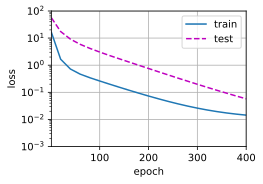

In [20]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[3.688569  2.8505056]]


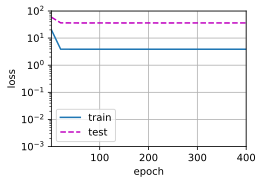

In [21]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[ 4.961619    1.2334331  -3.2243261   5.3135285  -0.58299583  1.0795269
  -0.06208075  0.3077543  -0.0980427  -0.17173347 -0.06310484 -0.18049373
  -0.15939292 -0.04294303  0.00971536 -0.17783028  0.1256392   0.08868623
   0.11715782  0.05905944]]


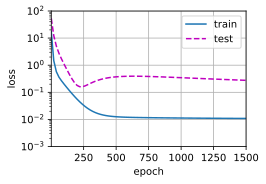

In [22]:
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)